In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

In [2]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [3]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  
                df = df.with_columns(pl.col(col).dt.total_days()) 
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [4]:
class Aggregator:
    
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        return  expr_max +expr_last
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [6]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [8]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [10]:
%time
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [11]:
%%time
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
        use.append(vx)
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    correlation_matrix = matrix.corr()
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

train data shape:	 (1526659, 861)
Memory usage of dataframe is 4322.75 MB
Memory usage after optimization is: 1528.81 MB
Decreased by 64.6%
train data shape:	 (1526659, 472)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D

In [12]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
device='gpu'
#n_samples=200000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:50000]
    #n_samples=10000
print(device)

cpu


In [13]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [14]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

test data shape:	 (10, 860)
train data shape:	 (50000, 389)
test data shape:	 (10, 388)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.02 MB
Decreased by 40.3%


0

In [15]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

In [16]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 600,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "alpha": 0.1,  
    "lambda": 10,  
    "tree_method": 'gpu_hist' if device == 'gpu' else 'auto',
    "random_state": 42,
    "verbosity": 0
}

fitted_models = []
cv_scores = []

for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
  
    model = xgb.train(params, dtrain, num_boost_round=params["n_estimators"],
                      evals=watchlist, early_stopping_rounds=100, verbose_eval=200)
    
    fitted_models.append(model)
    
    end_iteration = model.best_iteration + 1 if model.best_iteration else params["n_estimators"]
    y_pred_valid = model.predict(dvalid, iteration_range=(0, end_iteration))
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

[0]	train-auc:0.70237	valid-auc:0.64751
[181]	train-auc:0.98820	valid-auc:0.73343
[0]	train-auc:0.70782	valid-auc:0.67067
[200]	train-auc:0.98912	valid-auc:0.74143
[213]	train-auc:0.98998	valid-auc:0.74031
[0]	train-auc:0.67743	valid-auc:0.67698
[197]	train-auc:0.98654	valid-auc:0.77845
[0]	train-auc:0.68986	valid-auc:0.62665
[187]	train-auc:0.98509	valid-auc:0.74116
[0]	train-auc:0.72283	valid-auc:0.63371
[200]	train-auc:0.98908	valid-auc:0.72326
[202]	train-auc:0.98922	valid-auc:0.72340
CV AUC scores:  [0.7397231066556114, 0.7456849007133438, 0.7854618401478609, 0.7417501725327813, 0.7369001802359127]
Maximum CV AUC score:  0.7854618401478609


In [17]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)


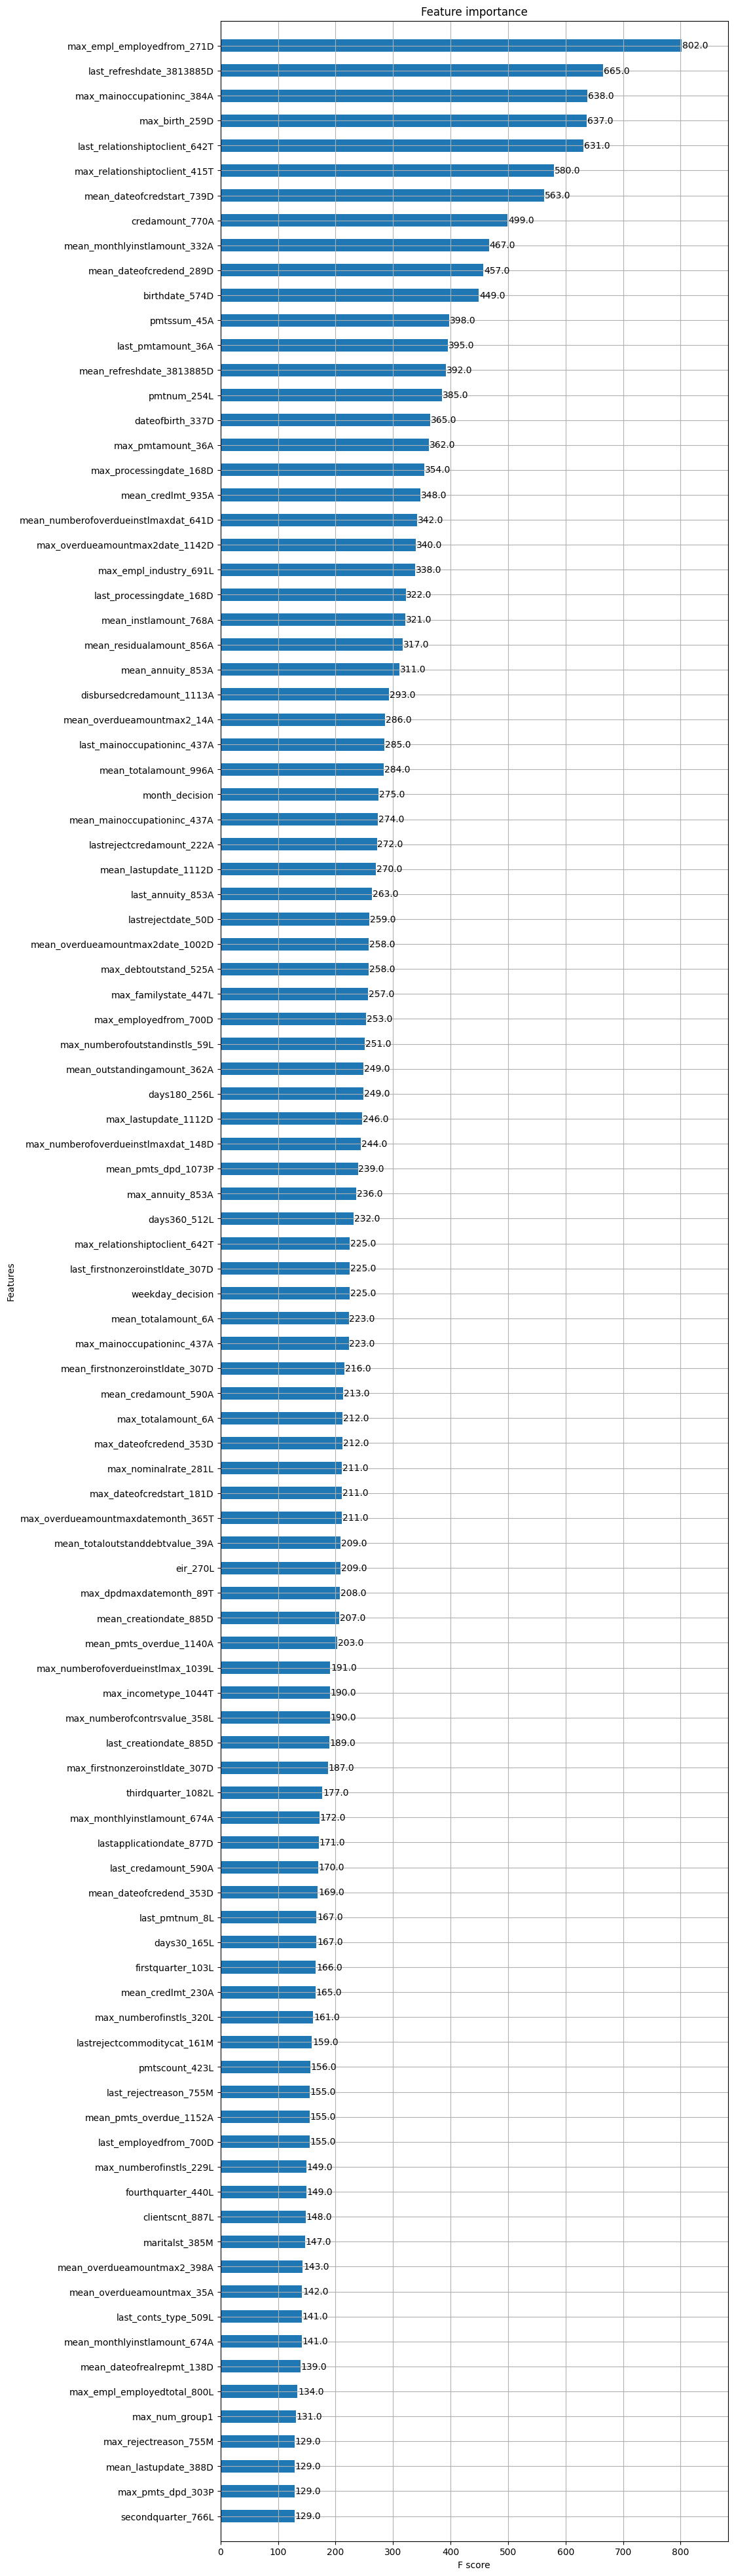

In [18]:
fig, ax = plt.subplots(figsize=(10, 50))

xgb.plot_importance(fitted_models[2], importance_type="weight", height=0.5, max_num_features=100, ax=ax)
plt.show()

In [19]:
importances = fitted_models[2].get_score(importance_type='weight')

features = list(importances.keys())
importance_values = list(importances.values())
feature_importance = pd.DataFrame({'features': features, 'importance': importance_values})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

print(feature_importance)

drop_list = [f['features'] for i, f in feature_importance.iterrows() if f['importance'] < 80]

print(f"Number of features which are not important: {len(drop_list)}")
print(drop_list)

                            features  importance
0         max_empl_employedfrom_271D       802.0
1          last_refreshdate_3813885D       665.0
2         max_mainoccupationinc_384A       638.0
3                     max_birth_259D       637.0
4     last_relationshiptoclient_642T       631.0
..                               ...         ...
292  pctinstlsallpaidlate4d_3546849L         1.0
293                    last_sex_738L         1.0
294                  clientscnt_493L         1.0
295     last_empls_economicalst_849M         1.0
296    last_empls_employer_name_740M         1.0

[297 rows x 2 columns]
Number of features which are not important: 173
['max_numberofoverdueinstlmax_1151L', 'max_num_group1_5', 'max_financialinstitution_591M', 'max_num_group1_15', 'last_pmts_year_507T', 'posfstqpd30lastmonth_3976962P', 'clientscnt_1022L', 'clientscnt_533L', 'max_dpdmaxdateyear_596T', 'max_postype_4733339M', 'last_num_group1', 'mobilephncnt_593L', 'homephncnt_628L', 'max_childnum_21L', 'cl

In [20]:
df_test = df_test.drop(columns=["WEEK_NUM"])
df_test = df_test.set_index("case_id")

In [21]:
dtest = xgb.DMatrix(df_test, enable_categorical=True)
y_pred = pd.Series(model.predict(dtest), index=df_test.index)

df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

df_subm.to_csv("submission.csv")
df_subm

,score
case_id,
57543,0.010575
57549,0.026809
57551,0.009973
57552,0.017614
57569,0.046458
57630,0.018087
57631,0.034438
57632,0.023390
57633,0.024913
